## RNN

### Import libraries

In [1]:
!pip install optuna

import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, LSTM
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Preprocessing module

In [2]:
# Load the data
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)
train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower() # convert text to lowercase
    text = re.sub(r'\b(u\.s\.|us)\b', 'usa', text, flags=re.IGNORECASE)  # replace "U.S." or "US" with "usa"
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML tags
    text = re.sub(r'&\w+;', '', text)  # remove HTML entities
    text = re.sub(r'[^a-z\s]', '', text)  # remove numbers and punctuation (keep only letters and spaces)
    words = text.split()
    words = [word for word in words if word not in stop_words] # remove stop-words, tokenization
    words = [lemmatizer.lemmatize(word) for word in words] # lemmatization
    return ' '.join(words) # combining words into a string

# Apply preprocessing
train_df['clean_text'] = (train_df['Title'] + ' ' + train_df['Description']).apply(preprocess_text)
test_df['clean_text'] = (test_df['Title'] + ' ' + test_df['Description']).apply(preprocess_text)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['clean_text'])
max_length_titles = max([len(x.split()) for x in train_df['Title']])
max_length_descriptions = max([len(x.split()) for x in train_df['Description']])

X_train_title_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Title']), maxlen=max_length_titles)
X_test_title_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Title']), maxlen=max_length_titles)
X_train_description_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Description']), maxlen=max_length_descriptions)
X_test_description_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Description']), maxlen=max_length_descriptions)

y_train = train_df['Class Index'].values - 1
y_test = test_df['Class Index'].values - 1

# Download and load GloVe embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

from google.colab import drive
drive.mount('/content/drive')

# Load GloVe embeddings
embedding_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)

Mounted at /content/drive


### Basic training module

In [4]:
# Define the baseline model with LSTM layers
title_input = Input(shape=(max_length_titles,), name='title_input')
title_embedding = embedding_layer(title_input)
title_lstm = LSTM(128, return_sequences=False)(title_embedding)

description_input = Input(shape=(max_length_descriptions,), name='description_input')
description_embedding = embedding_layer(description_input)
description_lstm = LSTM(128, return_sequences=False)(description_embedding)

merged = Concatenate()([title_lstm, description_lstm])
dense_1 = Dense(128, activation='relu')(merged)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(4, activation='softmax')(dense_2)

model = Model(inputs=[title_input, description_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the baseline model
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1,
          epochs=5, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.7937 - loss: 0.6389 - val_accuracy: 0.8759 - val_loss: 0.3438
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8800 - loss: 0.3465 - val_accuracy: 0.8823 - val_loss: 0.3257
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8858 - loss: 0.3265 - val_accuracy: 0.8835 - val_loss: 0.3183
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8885 - loss: 0.3149 - val_accuracy: 0.8876 - val_loss: 0.3076
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8925 - loss: 0.3064 - val_accuracy: 0.8890 - val_loss: 0.3042


### Testing Module 1 (Base Model)

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Baseline Test Accuracy: 0.8895
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1900
           1       0.94      0.97      0.95      1900
           2       0.83      0.86      0.85      1900
           3       0.87      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



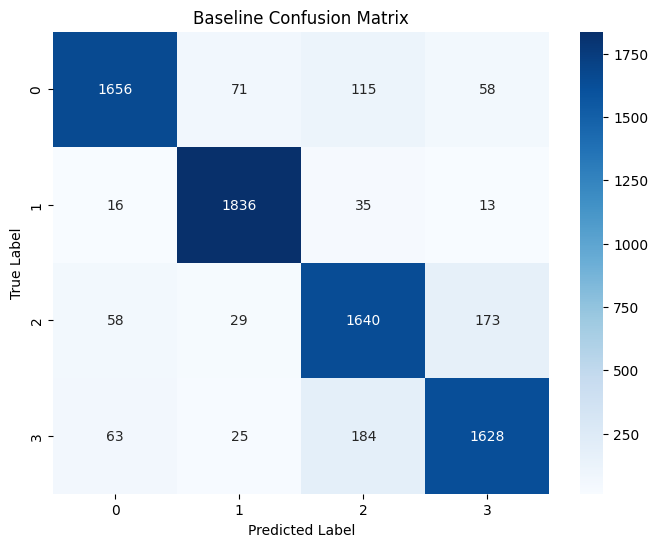

In [5]:
# Evaluate baseline model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

baseline_accuracy = (y_pred_classes == y_test).mean()
print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Confusion Matrix')
plt.show()

### Hyperparameter selection module

In [6]:
def model_builder(trial):
    # Define hyperparameters for optimization
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    lstm_units = trial.suggest_int('lstm_units', 64, 256)
    num_units = trial.suggest_int('num_units', 64, 512)

    # Define model structure with Optuna parameters
    title_input = Input(shape=(max_length_titles,), name='title_input')
    title_embedding = embedding_layer(title_input)
    title_lstm = LSTM(lstm_units, return_sequences=False)(title_embedding)

    description_input = Input(shape=(max_length_descriptions,), name='description_input')
    description_embedding = embedding_layer(description_input)
    description_lstm = LSTM(lstm_units, return_sequences=False)(description_embedding)

    merged = Concatenate()([title_lstm, description_lstm])
    dense_1 = Dense(num_units, activation='relu')(merged)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)

    model = Model(inputs=[title_input, description_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna
def objective(trial):
    model = model_builder(trial)
    model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=3, batch_size=32, verbose=1)
    _, accuracy = model.evaluate([X_test_title_pad, X_test_description_pad], y_test, verbose=1)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Best Trial:", study.best_trial)

[I 2024-10-29 19:30:40,422] A new study created in memory with name: no-name-cdde670e-dc48-4b34-b296-d373a0e0f01a


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.7984 - loss: 0.6050 - val_accuracy: 0.8836 - val_loss: 0.3338
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.8801 - loss: 0.3482 - val_accuracy: 0.8788 - val_loss: 0.3311
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.8860 - loss: 0.3272 - val_accuracy: 0.8850 - val_loss: 0.3194
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8802 - loss: 0.3436


[I 2024-10-29 19:32:39,653] Trial 0 finished with value: 0.8834210634231567 and parameters: {'dropout_rate': 0.24239357139723888, 'learning_rate': 2.86820799662818e-05, 'lstm_units': 209, 'num_units': 242}. Best is trial 0 with value: 0.8834210634231567.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.8622 - loss: 0.3978 - val_accuracy: 0.8925 - val_loss: 0.3063
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9051 - loss: 0.2739 - val_accuracy: 0.8985 - val_loss: 0.2899
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9138 - loss: 0.2425 - val_accuracy: 0.8959 - val_loss: 0.2970
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8915 - loss: 0.3199


[I 2024-10-29 19:34:28,856] Trial 1 finished with value: 0.8953947424888611 and parameters: {'dropout_rate': 0.029049853984764562, 'learning_rate': 0.005599330273919606, 'lstm_units': 248, 'num_units': 126}. Best is trial 1 with value: 0.8953947424888611.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.8652 - loss: 0.3968 - val_accuracy: 0.8903 - val_loss: 0.3034
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8992 - loss: 0.3008 - val_accuracy: 0.8967 - val_loss: 0.2942
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9098 - loss: 0.2662 - val_accuracy: 0.8945 - val_loss: 0.3103
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8974 - loss: 0.3147


[I 2024-10-29 19:36:17,161] Trial 2 finished with value: 0.8998684287071228 and parameters: {'dropout_rate': 0.47887459365601603, 'learning_rate': 0.004524004939365907, 'lstm_units': 105, 'num_units': 205}. Best is trial 2 with value: 0.8998684287071228.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.7982 - loss: 0.5920 - val_accuracy: 0.8783 - val_loss: 0.3406
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.8785 - loss: 0.3531 - val_accuracy: 0.8840 - val_loss: 0.3214
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8855 - loss: 0.3274 - val_accuracy: 0.8890 - val_loss: 0.3126
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8827 - loss: 0.3330


[I 2024-10-29 19:38:07,389] Trial 3 finished with value: 0.887499988079071 and parameters: {'dropout_rate': 0.4402739441459317, 'learning_rate': 4.4639526412095084e-05, 'lstm_units': 168, 'num_units': 204}. Best is trial 2 with value: 0.8998684287071228.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.8549 - loss: 0.4158 - val_accuracy: 0.8905 - val_loss: 0.2971
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.8955 - loss: 0.2968 - val_accuracy: 0.8987 - val_loss: 0.2745
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9100 - loss: 0.2549 - val_accuracy: 0.8959 - val_loss: 0.2824
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9054 - loss: 0.2731


[I 2024-10-29 19:39:54,966] Trial 4 finished with value: 0.9027631282806396 and parameters: {'dropout_rate': 0.3748942340245407, 'learning_rate': 0.0003807838415100024, 'lstm_units': 158, 'num_units': 240}. Best is trial 4 with value: 0.9027631282806396.


Best Trial: FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.9027631282806396], datetime_start=datetime.datetime(2024, 10, 29, 19, 38, 7, 390831), datetime_complete=datetime.datetime(2024, 10, 29, 19, 39, 54, 966265), params={'dropout_rate': 0.3748942340245407, 'learning_rate': 0.0003807838415100024, 'lstm_units': 158, 'num_units': 240}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'lstm_units': IntDistribution(high=256, log=False, low=64, step=1), 'num_units': IntDistribution(high=512, log=False, low=64, step=1)}, trial_id=4, value=None)


### Testing module 2 (Optimized Model)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.8589 - loss: 0.4096 - val_accuracy: 0.8799 - val_loss: 0.3252
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.8977 - loss: 0.2908 - val_accuracy: 0.8957 - val_loss: 0.2804
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.9099 - loss: 0.2578 - val_accuracy: 0.8967 - val_loss: 0.2803
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.9201 - loss: 0.2259 - val_accuracy: 0.9032 - val_loss: 0.2704
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9270 - loss: 0.2034 - val_accuracy: 0.9013 - val_loss: 0.2772
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Final Test Accuracy: 0.9071
Final Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1900
           1       0.95      0.97      0.96      1900
           2       0.89      0.86      0.87      1900
           3       0.86      0

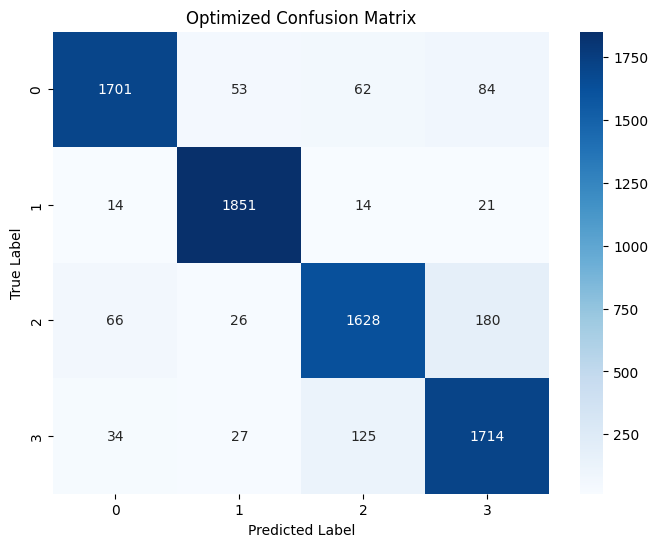

In [7]:
# Load the best model from Optuna optimization
best_trial = study.best_trial
model = model_builder(best_trial)
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=5, batch_size=32, verbose=1)

# Evaluate optimized model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

final_accuracy = (y_pred_classes == y_test).mean()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print("Final Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix for optimized model
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Optimized Confusion Matrix')
plt.show()